In [1]:
# ! conda install tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import PIL
import tensorflow as tf
import tensorflow.keras.layers as tfl
import time

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
# from tensorbay import GAS
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
# import cv
import random
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
# from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split


%matplotlib inline



# 1) Data Preparation

In [2]:
def dataConverter(folder_name, bw=True):
    train_data = []
    image_no = []
    for image in os.listdir(folder_name):
        if bw == True:
            img_array = np.asarray(PIL.Image.open(f'{folder_name}/{image}').convert("L"))
        else:
            img_array = np.asarray(PIL.Image.open(f'{folder_name}/{image}'))
        train_data.append(img_array)
        image_no.append(int(image[:-4]))
    train_data = np.array(train_data)
    return(np.array(train_data[:,:,:,:3]), image_no)

train_data, image_no = dataConverter('train_val', bw=False)
train_data.shape

(1000, 128, 128, 3)

In [3]:
num_df = pd.DataFrame({'image_index':image_no})
cat_df = pd.read_csv('train_val.csv')
final_df = pd.merge(num_df, cat_df, on='image_index', how='inner')
print(num_df)
print(final_df)

     image_index
0              0
1              1
2             10
3            100
4            101
..           ...
995          995
996          996
997          997
998          998
999          999

[1000 rows x 1 columns]
     image_index              type
0              0  vbar_categorical
1              1  vbar_categorical
2             10  vbar_categorical
3            100  vbar_categorical
4            101  vbar_categorical
..           ...               ...
995          995          dot_line
996          996          dot_line
997          997          dot_line
998          998          dot_line
999          999          dot_line

[1000 rows x 2 columns]


In [4]:
# Converting categorical lables into binary array.
lb = LabelBinarizer()
y = lb.fit_transform(final_df.type)
print(lb.classes_)
print(y, y.shape)
print(train_data.shape)

['dot_line' 'hbar_categorical' 'line' 'pie' 'vbar_categorical']
[[0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ...
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]] (1000, 5)
(1000, 128, 128, 3)


In [5]:
# Splitting data into train and validation sets.
train_idx = random.sample(range(1000), 850)
val_idx = np.array([i for i in range(1000) if i not in train_idx])

# Creating Normalized train and validation Sets.
x_train = train_data[train_idx,:]/255.0
x_val = train_data[val_idx,:]/255.0
y_train = y[train_idx,:]
y_val = y[val_idx,:]

# 2) Model Creation

In [13]:
def model1(input_shape):
    ''' input shape -> tuple(pixcel, pixcel, channels) '''
    
    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4,4), strides=(1,1), padding = 'same')(input_img)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=None, padding='valid')(A1)
    Z2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding = 'same')(P1)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=None, padding='same')(A2)
    F = tf.keras.layers.Flatten()(P2)
    D1 = tf.keras.layers.Dense(32, activation="relu")(F)
    outputs = tf.keras.layers.Dense(5 ,activation="softmax")(D1)

    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [14]:
model1 = model1((128,128,3))
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 8)       392       
                                                                 
 re_lu_2 (ReLU)              (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 16)        528       
                                                                 
 re_lu_3 (ReLU)              (None, 42, 42, 16)        0         
                                                           

In [15]:
# Compiling model
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])
# Training the model
epochs = 20
batch_size = 28
history = model1.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))
# Saving model
model1.save("output/model1.h5")

Epoch 1/20
31/31 [==============================] - 1s 34ms/step - loss: 1.5285 - accuracy: 0.3494 - val_loss: 1.3776 - val_accuracy: 0.5867
Epoch 2/20
31/31 [==============================] - 1s 30ms/step - loss: 1.2405 - accuracy: 0.5741 - val_loss: 1.0472 - val_accuracy: 0.6933
Epoch 3/20
31/31 [==============================] - 1s 30ms/step - loss: 0.8508 - accuracy: 0.7859 - val_loss: 0.6768 - val_accuracy: 0.8400
Epoch 4/20
31/31 [==============================] - 1s 34ms/step - loss: 0.5296 - accuracy: 0.8600 - val_loss: 0.4369 - val_accuracy: 0.9067
Epoch 5/20
31/31 [==============================] - 1s 32ms/step - loss: 0.3590 - accuracy: 0.9141 - val_loss: 0.3231 - val_accuracy: 0.8933
Epoch 6/20
31/31 [==============================] - 1s 31ms/step - loss: 0.2970 - accuracy: 0.9024 - val_loss: 0.2446 - val_accuracy: 0.9400
Epoch 7/20
31/31 [==============================] - 1s 30ms/step - loss: 0.2165 - accuracy: 0.9400 - val_loss: 0.2019 - val_accuracy: 0.9267
Epoch 8/20
31

# 3) Visualizing the model training and loss history.

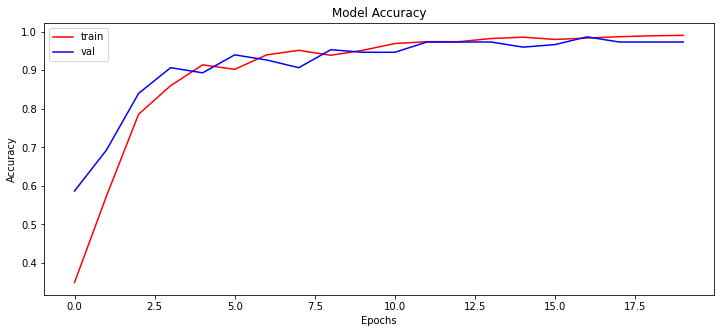

In [16]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

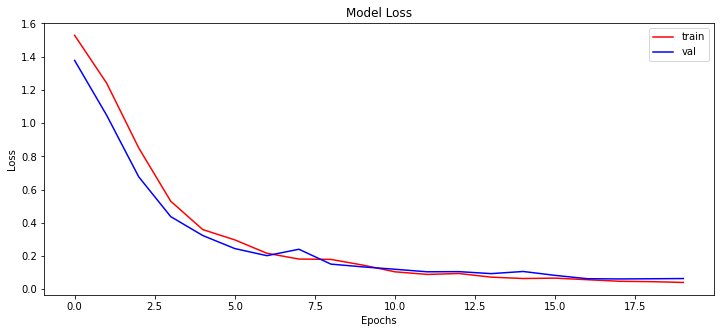

In [17]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

# 4) Comparing the results.

In [18]:
# Converting Test data to Proper Format.
test_data, image_no = dataConverter('test', bw=False)
test_data = np.array(test_data)
x_test = test_data/255
x_test.shape

(50, 128, 128, 3)

2/2 [==============================] - 0s 7ms/step
vbar_categorical


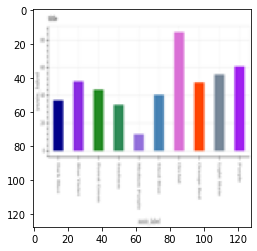

hbar_categorical


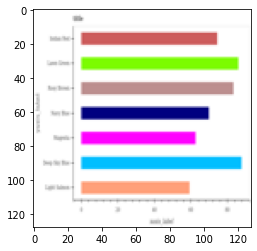

dot_line


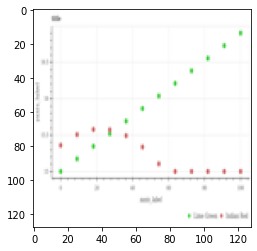

hbar_categorical


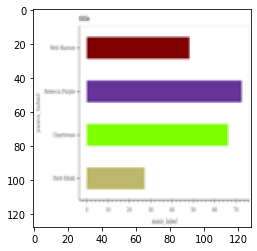

line


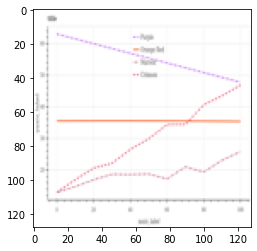

line


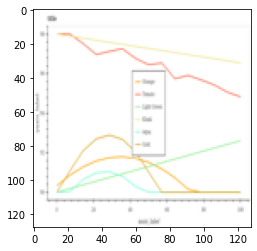

pie


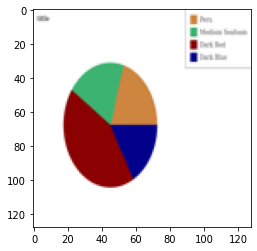

line


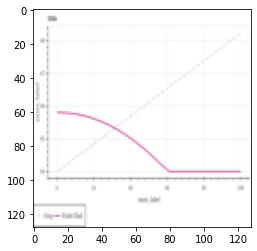

hbar_categorical


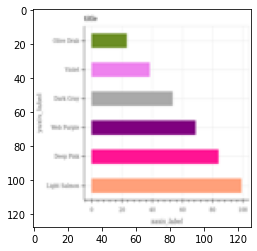

vbar_categorical


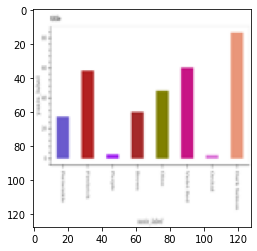

dot_line


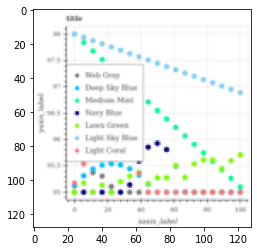

hbar_categorical


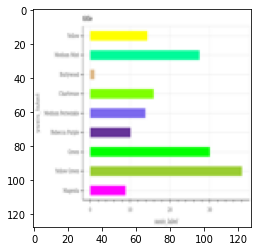

vbar_categorical


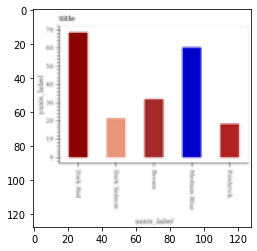

dot_line


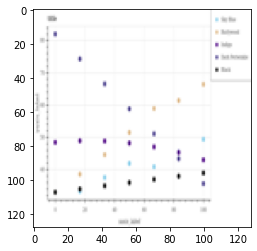

pie


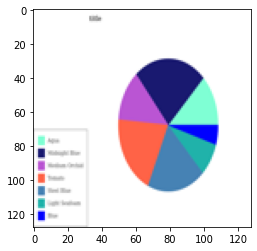

dot_line


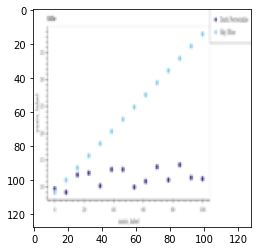

pie


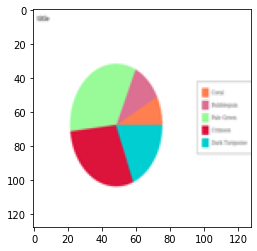

vbar_categorical


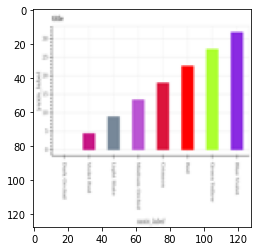

hbar_categorical


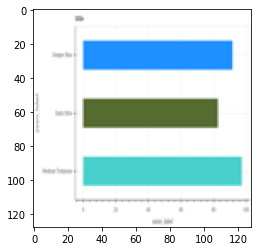

hbar_categorical


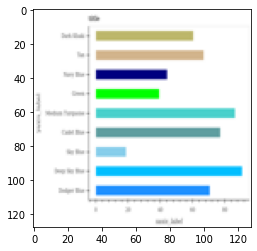

dot_line


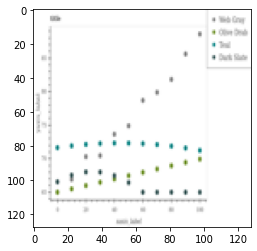

pie


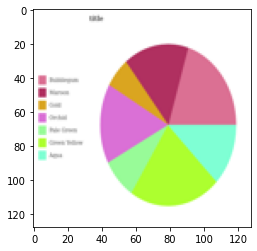

pie


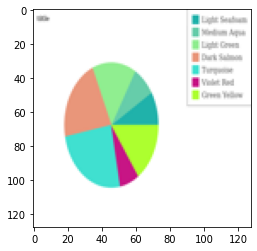

hbar_categorical


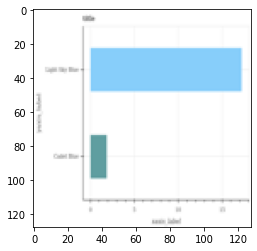

hbar_categorical


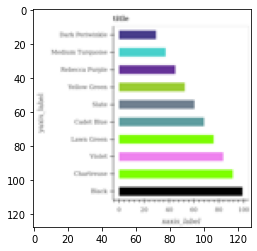

line


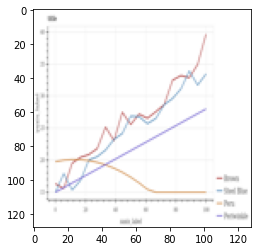

vbar_categorical


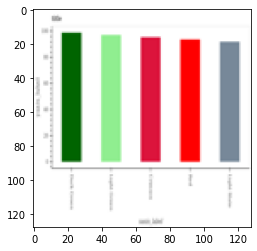

hbar_categorical


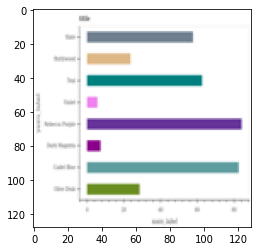

hbar_categorical


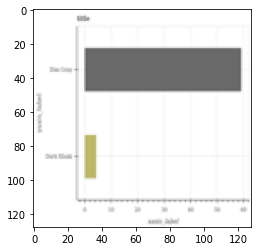

line


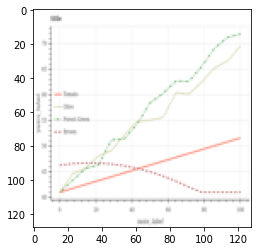

vbar_categorical


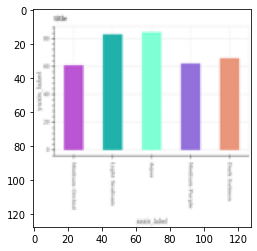

dot_line


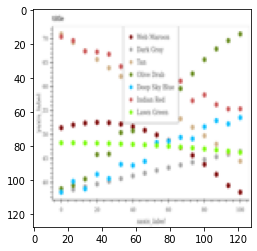

vbar_categorical


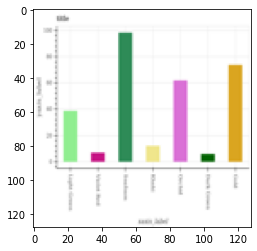

dot_line


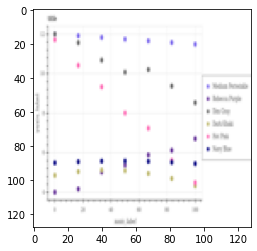

line


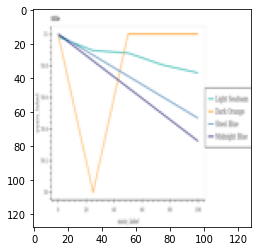

dot_line


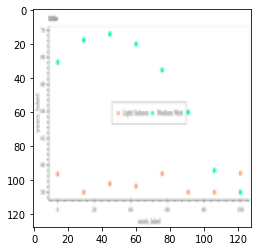

vbar_categorical


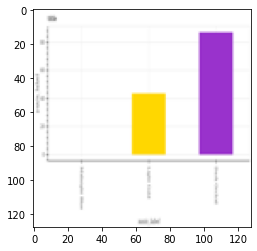

pie


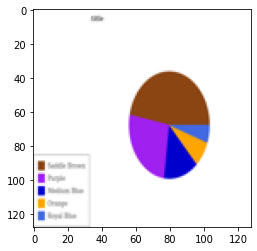

hbar_categorical


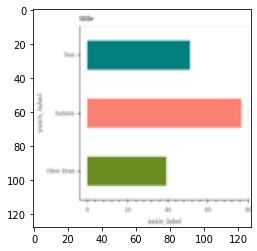

pie


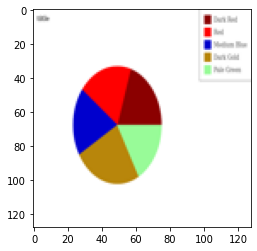

hbar_categorical


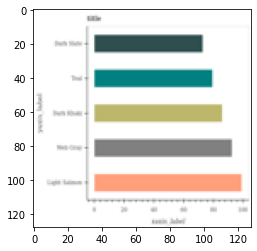

line


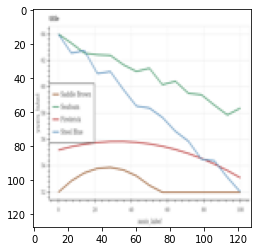

pie


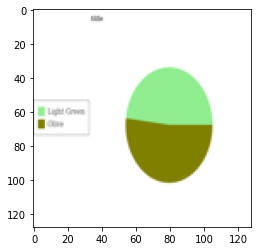

pie


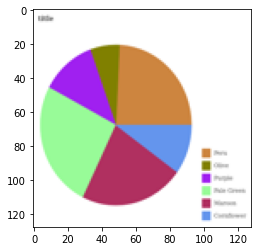

line


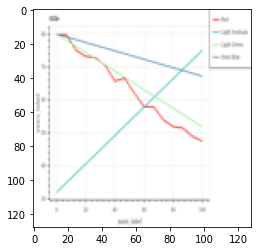

line


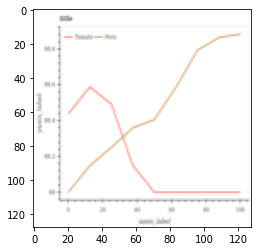

vbar_categorical


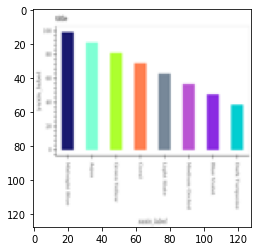

vbar_categorical


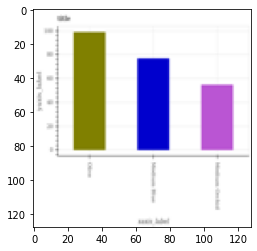

line


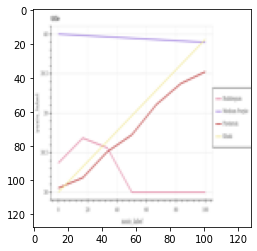

line


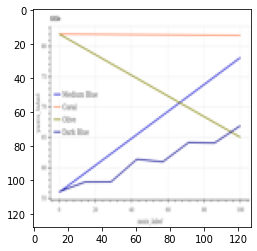

In [19]:
# Storing predictions
inp_test_array,_ = dataConverter('test', bw=False)
y_pred = model1.predict(x_test)
# print(y_pred)

# Finding max value from prediction list.
y_result = []
labels = lb.classes_
# print(labels)
for pred in y_pred:
    y_result.append(labels[np.argmax(pred)])

# Plotting image to compare
for i in range(len(y_pred)):
    print(y_result[i])
    plt.imshow(inp_test_array[i,:,:,:], cmap='gray')
    plt.show()


# img = array_to_img(x_test[4,:,:,1]*255)
# img

In [ ]:
BATCH_SIZE = 15
IMG_SIZE = (128, 128)
directory = "train_val"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)